In [1]:
## VISSIM Modules
import win32com.client as com
import os

## RL Modules
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("ERROR: GPU DEVICE NOT FOUND.")

from tensorflow.keras.models import load_model
    
## Data Management Modules
import pickle

## User Defined Modules
import math
import Simulator_Functions as SF

from Actor_Critic_Agents import ACAgent

from RLAgents import DQNAgent
from NParser import NetworkParser
from COMServer import COMServerDispatch, COMServerReload
from TupleToList import toList
from Utilities import log_progress, pltlive
## Other Modules
import numpy as np
import random
import matplotlib.pyplot as plt
import PER

%matplotlib inline

ERROR: GPU DEVICE NOT FOUND.


In [2]:
## RL Hyperparamenters
# Number of simulations, save every "n" episodes and copy weights with frequency "f"
episodes = 400
partial_save_at = 25 # 100 
copy_weights_frequency = 10 #10


# Hyperparameters
Surtrac = False
PER_activated = True
batch_size = 64
memory_size = 1024
alpha   = 0.000015
gamma   = 0.99

# Timesteps per simulation (1 timestep = 0.1 sec), length for random population is a multiple of episode
timesteps_per_second = 1
seconds_per_green = 6
seconds_per_yellow = 3
simulation_length = 3600*1 + 1
Random_Seed = 42
memory_population_length = batch_size*seconds_per_green*2 +1
if PER_activated:
    memory_population_length = int(memory_size*seconds_per_green*2) +1

# Vissim autosave the result of the simulation    
delete_results = True

## State-Action Parameters
action_type = "phases"        # options are "phases" and "programs"
state_size = 5 #4  17 33 49 97
action_size = 2 # 8 



# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "geometric"
epsilon_start = 1
epsilon_end   = 0.001
if exploration_schedule == "linear":
    epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
    epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
    epsilon_sequence = [0 if entry < 0 else entry for entry in epsilon_sequence]
elif exploration_schedule == "geometric":
    epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
    epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
else:
    print("ERROR: Unrecognized choice of exploration schedule.")

# Demand Schedule (times in seconds, demand in cars/hour as PPP)  # worked with 600 and demand = {"h":600, 'm':300, 'l':150}
demand_change_timesteps = 450
demand = {"h":600, 'm':300, 'l':150}
demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
              [demand['h'], demand['l']], [demand['h'], demand['m']],\
              [demand['h'], demand['h']], [demand['m'], demand['h']],
              [demand['l'], demand['h']], [demand['l'], demand['m']]]

In [3]:
## Operation mode (selects functionalities)
mode = "training"
# "populate" = population of memory, generation of initial memory file
# "training" = training agents, maximum speed, frozen UI, mid amount of messages
# "debug"    = trains for 1 episode, minimum speed, working UI, all messages
# "demo"     = loads pretrained agent, minimum speed, working UI
# "test"     = executes evaluation, maximum speed
# "retraining" = continue to train agents, maximum speed, frozen UI, mid amount of messages. T

if mode == 'demo' :
    simulation_length = 3600
    demand_list = [[demand['l'], demand['l']]]
    demand_change_timesteps = simulation_length
    
    
if mode == 'test' : 
    simulation_length = 3601
    demand_change_timesteps = 450
    demand = {"h":800, 'm':400, 'l':200}
    demand_list = [[demand['l'], demand['l']], [demand['m'], demand['l']],\
                  [demand['h'], demand['l']], [demand['h'], demand['m']],\
                  [demand['h'], demand['h']], [demand['m'], demand['h']],
                  [demand['l'], demand['h']], [demand['l'], demand['m']]]
    delete_results = False
    Random_Seed = 1
    
model_name  = 'Single_Cross_Mod2'
# 'Single_Cross_Straight'
# 'Single_Cross_Triple'
# 'Single_Cross_Triple_Mod'
# 'Single_Cross_Mod2'
# 'Balance'

vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'  #'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Vissim\\'
agent_type = 'DuelingDDQN'        # DQN, DuelingDQN, DDQN, DuelingDDQN AC
reward_type = 'Queues'   
# 'Queues'          Sum of the queues for all lanes in intersection
# 'QueuesDiff'      Difference in queue lengths in last timestep
# 'QueuesDiffSC'    10000* QueuesDiff - Queues^2
# 'TotalDelayDiff'
state_type  = 'QueuesSig'
#CellsSpeedOccSig'    # 'Queues', 'Delays', 'QueuesDifference' 'QueuesSpeedavrOccuperateSig' 'QueuesSig' CellsSpeedSig 
#CellsSpeedOccSig 'CellsOccSig' 'CellsT'


#hyper parameters of the AC agent
if agent_type == 'AC':
    alpha   = 0.000005
    gamma   = 0.99
    n_step_size = 16 # number of step in the n step learning # 32
    PER_activated = False
    entropy = 0.00001



## Use of additional files?
flag_read_additionally  = False
SaveResultsAgent = True
# Random demand
Random_Demand = False

# Session ID
# Adding the state type to the Session_ID
Session_ID = 'Ep_'+str(episodes)+'_A_'+agent_type+"_State_"+state_type+"_Act_"+action_type+"_Rew_"+reward_type
print(Session_ID)

Ep_400_A_DuelingDDQN_State_QueuesSig_Act_phases_Rew_Queues


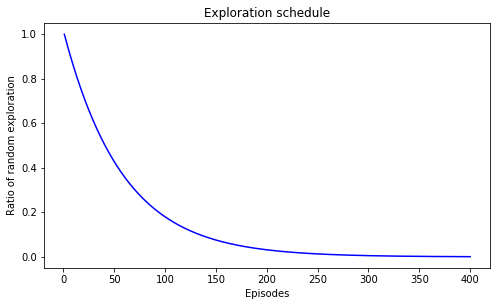

In [4]:
# Plotting exploration schedule
plt.figure(figsize=(8,4.5))
x_series = np.array(range(1,episodes+1))
y_series = epsilon_sequence[0:episodes]
plt.plot(x_series, y_series, '-b')
plt.xlabel('Episodes')
plt.ylabel('Ratio of random exploration')
plt.title('Exploration schedule')
plt.show()

In [ ]:
# Have to find a way to reduce entropy over time entropy = exploration

## Converging network
# - reward queue, state queue
# converging with updates every steps and entropy = 0.00001 and 1 core layer of 42
# converging well with updates every steps and entropy = 0.00001 and 1 core layer of 128

# - reward queue state queues + sig
# converging well with updates every steps and entropy = 0.00001 and 1 core layer of 128





if __name__ == "__main__":
    # Initialize storage
    reward_storage = []
    best_agent_weights = []
    best_agent_memory = []
    reward_plot = np.zeros([episodes,])
    loss_plot = np.zeros([episodes,])

    # Initialize simulation
    Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                                memory_population_length if mode == 'training'\
                                                                and PER_activated else simulation_length ,\
                                                                timesteps_per_second,\
                                                                delete_results = delete_results, verbose = True)
    
    SF.Select_Vissim_Mode(Vissim,mode)
        
    # Setting Random Seed
    Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
    print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

    # Deploy Network Parser (crawl network)
    npa = NetworkParser(Vissim)
    print('NetworkParser has succesfully crawled the model network.')
    
    # Initialize agents
    if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
        Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or agent_type =="DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or agent_type == "DDQN" else True) for ID in npa.signal_controllers_ids] 
        agents_deployed = True
    elif agent_type in ['AC'] :
        Agents = [ACAgent(state_size, action_size, ID, state_type, npa, n_step_size, gamma, alpha, entropy, Vissim) for ID in npa.signal_controllers_ids] 
        for agent in Agents:
            # to initialise the computational graph ot the model (I am sure there is a better way to to this)
            agent.test()
        agents_deployed = True
    else:
        print("Incorrect Agent Class selected. Deployment could not be completed.")
        quit()
    if agents_deployed:
        print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))
    
    ## EXECUTION OF A DEMONSTRATION, POPULATION, DEBUG OR TEST ITERATION
    if mode == "demo" or mode == "populate" or mode == "debug" or mode == "test":
        # If mode or debug, set slow simulation
        if mode == "demo" or mode =="debug":
            timesteps_per_second = 10
            Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
            
        # If memory population or test mode, set quick simulation
        elif mode == "populate" or mode == "test":
            SF.Set_Quickmode(Vissim, timesteps_per_second)
            
        # If on a test or a demo, load the best available agent and set exploration to zero
        if mode == "demo" or mode == "test":
            Agents, reward_storage = SF.load_agents(vissim_working_directory, model_name, Agents,\
                                    Session_ID, best = True)
            for agent in Agents:
                agent.epsilon = 0    #1
        
        # Run the episode
        if mode == "demo" or mode == "debug":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "test":
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                                      timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                                      demand_list, demand_change_timesteps, mode, PER_activated)
        elif mode == "populate":
            if PER_activated:
                memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                                vissim_working_directory, model_name, Session_ID,\
                                                                seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                                demand_list, demand_change_timesteps, PER_activated)
                print("PER memory prepopulated with {} entries".format(memory_size))
        
        Vissim = None
     
    ## EXECUTION OF THE NORMAL TRAINING LOOP
    elif mode == "training":
        
        if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
            
            # Load previous memory if available, else create it
            SF.Select_Vissim_Mode(Vissim, mode)
            memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
                                                            vissim_working_directory, model_name, Session_ID,\
                                                            seconds_per_green, seconds_per_green, timesteps_per_second,\
                                                            demand_list, demand_change_timesteps, PER_activated)
            print('Memory pre-populated. Starting Training.\n')
        
        # Iterations of the simulation
        runflag = True
        for episode in log_progress(range(episodes), every=1):
        
            # Reload map if it has already been run (previous episode or prepopulation)
            if episode !=0 or runflag == True:
                Simulation, Network = COMServerReload(Vissim, model_name, vissim_working_directory,\
                                                      simulation_length, timesteps_per_second, delete_results = True)

                # Run Network Parser and ensure agents are linked to their intersections
                npa = NetworkParser(Vissim)
                for index, agent in enumerate(Agents):
                    agent.update_IDS(agent.signal_id, npa)
                    agent.episode_reward = []

            # Change the random seed
            Random_Seed += 1
            Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
                    
            # Run Episode at maximum speed
            SF.Select_Vissim_Mode(Vissim, mode)
            SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length, timesteps_per_second,\
                                      seconds_per_green, seconds_per_yellow, demand_list, demand_change_timesteps, mode,\
                                      PER_activated)
        
            # Calculate episode average reward
            reward_storage, average_reward = SF.average_reward(reward_storage, Agents, episode, episodes)
            best_agent_weights, best_agent_memory = SF.best_agent(reward_storage, average_reward,\
                                                                  best_agent_weights, best_agent_memory,\
                                                                  vissim_working_directory, model_name, Agents, Session_ID)
        
           
             # Train agent with experience of episode and copy weights when necessary
            # Update exploration rate
            for agent in Agents: 
                if agent.type == 'DQN':
                    for _ in range(3):
                        agent.learn_batch(batch_size, episode)
                # Copy weights 
                    if (episode+1) % agent.copy_weights_frequency == 0 and episode != 0:
                        agent.copy_weights()
                    agent.epsilon = epsilon_sequence[episode+1]
            
            # Security save for long trainings
            if SaveResultsAgent:
                if (episode+1)%partial_save_at == 0:
                    SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
                    print('Saved Partial results at the end of episode {}.'.format(episode+1))

        #Saving agents memory, weights and optimizer
        if SaveResultsAgent:
            SF.save_agents(vissim_working_directory, model_name, Agents, Session_ID, reward_storage)
            print("Model, architecture, weights, optimizer, memory and training results succesfully saved.\
            Succesfully Terminated.")
    
    else:
        raise Exception("ERROR: Mode selected not recognized. TERMINATING.")
    # Close Vissim
    Vissim = None

Working Directory set to: C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Mod2.inpx ...
Load process successful
Simulation length set to 12289 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Simulation Object
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                 SETUP COMPLETE                      *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 42
NetworkParser has succesfully crawled the model network.
Deploying instance of Dueling Double Deep Q Learning Agent(s)
Deployed 1 agent(s) of the Class DuelingDDQN.
Previous Experienc

Episode: 1/400, Epsilon:1.0, Average reward: -57.23
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_DuelingDDQN_State_QueuesSig_Act_phases_Rew_Queues\BestAgent0_Memory.p
Train on 64 samples
64/64 - 0s - loss: 7613.7349
Train on 64 samples
64/64 - 0s - loss: 9487.1406
Train on 64 samples
64/64 - 0s - loss: 8624.2910
Episode: 2/400, Epsilon:0.98, Average reward: -64.67
Train on 64 samples
64/64 - 0s - loss: 4100.4404
Train on 64 samples
64/64 - 0s - loss: 3496.2715
Train on 64 samples
64/64 - 0s - loss: 5322.7920
Episode: 3/400, Epsilon:0.97, Average reward: -49.75
New best agent found. Saved in C:\Users\Rzhang\Desktop\MLforFlowOptimisationOrigine\Vissim\Single_Cross_Mod2\Agents_Results\Ep_400_A_DuelingDDQN_State_QueuesSig_Act_phases_Rew_Queues\BestAgent0_Memory.p
Train on 64 samples
64/64 - 0s - loss: 2729.2759
Train on 64 samples
64/64 - 0s - loss: 2508.6445
Train on 64 samples
64/64 - 0s - loss: 2919.

Train on 64 samples
64/64 - 0s - loss: 30201.7578
Episode: 36/400, Epsilon:0.55, Average reward: -198.76
Train on 64 samples
64/64 - 0s - loss: 36500.2891
Train on 64 samples
64/64 - 0s - loss: 36266.9102
Train on 64 samples
64/64 - 0s - loss: 32718.2266
Episode: 37/400, Epsilon:0.54, Average reward: -266.57
Train on 64 samples
64/64 - 0s - loss: 39609.1797
Train on 64 samples
64/64 - 0s - loss: 44527.6172
Train on 64 samples
64/64 - 0s - loss: 43167.3594
Episode: 38/400, Epsilon:0.53, Average reward: -294.31
Train on 64 samples
64/64 - 0s - loss: 58956.9922
Train on 64 samples
64/64 - 0s - loss: 54172.1797
Train on 64 samples
64/64 - 0s - loss: 58089.9375
Episode: 39/400, Epsilon:0.52, Average reward: -218.21
Train on 64 samples
64/64 - 0s - loss: 54750.3672
Train on 64 samples
64/64 - 0s - loss: 53866.9883
Train on 64 samples
64/64 - 0s - loss: 53185.7031
Episode: 40/400, Epsilon:0.51, Average reward: -293.99
Train on 64 samples
64/64 - 0s - loss: 40757.9062
Train on 64 samples
64/64

Episode: 74/400, Epsilon:0.28, Average reward: -251.69
Train on 64 samples
64/64 - 0s - loss: 54706.3984
Train on 64 samples
64/64 - 0s - loss: 52967.2969
Train on 64 samples
64/64 - 0s - loss: 53955.4453
Episode: 75/400, Epsilon:0.28, Average reward: -362.98
Train on 64 samples
64/64 - 0s - loss: 72268.2188
Train on 64 samples
64/64 - 0s - loss: 71050.3750
Train on 64 samples
64/64 - 0s - loss: 73533.5391
Saving architecture, weights and optimizer state for agent-0
Dumping agent-0 memory into pickle file
Dumping Training Results into pickle file.
Dumping Loss Results into pickle file.
Saved Partial results at the end of episode 75.
Episode: 76/400, Epsilon:0.27, Average reward: -382.56
Train on 64 samples
64/64 - 0s - loss: 97339.2422
Train on 64 samples
64/64 - 0s - loss: 97162.4375
Train on 64 samples
64/64 - 0s - loss: 89380.7812
Episode: 77/400, Epsilon:0.27, Average reward: -369.42
Train on 64 samples
64/64 - 0s - loss: 87650.5469
Train on 64 samples
64/64 - 0s - loss: 92095.8281

In [ ]:
Agents[0].DoubleDQN


[autoreload of tensorflow.python.keras.layers.core failed: Traceback (most recent call last):
  File "C:\Users\Rzhang\Anaconda3\envs\tf2\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Rzhang\Anaconda3\envs\tf2\lib\site-packages\IPython\extensions\autoreload.py", line 378, in superreload
    module = reload(module)
  File "C:\Users\Rzhang\Anaconda3\envs\tf2\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\Rzhang\Anaconda3\envs\tf2\lib\importlib\__init__.py", line 148, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module RLAgents not in sys.modules
]


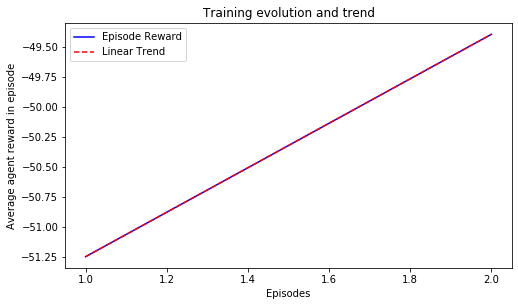

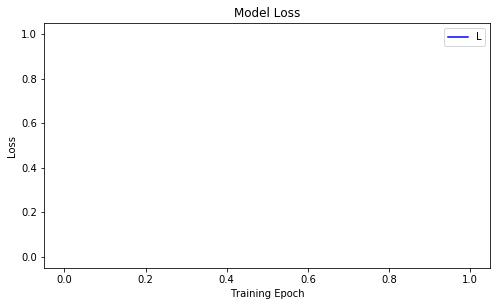

In [6]:
# Plotting training progress
plt.figure(figsize=(8,4.5))
x_series = range(1,len(reward_storage)+1)
fit = np.polyfit(x_series,reward_storage,1)
fit_fn = np.poly1d(fit) 
plt.plot(x_series,reward_storage, '-b', x_series, fit_fn(x_series), '--r')
plt.xlabel('Episodes')
plt.ylabel('Average agent reward in episode')
plt.title('Training evolution and trend')
plt.gca().legend(('Episode Reward','Linear Trend'))
plt.show()

# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

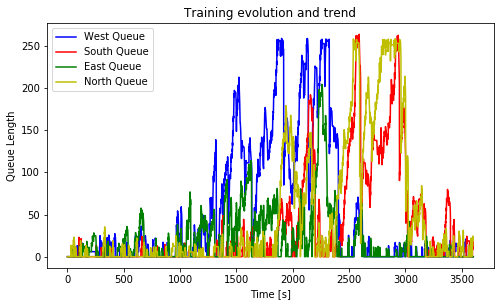

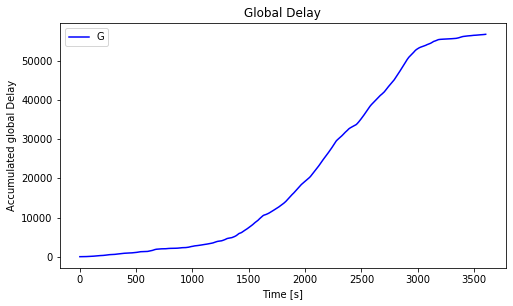

Average queue size is 38.36


In [7]:
# Plotting test progress:
West_queue = list()
South_queue= list()
East_queue = list()
North_queue= list()
# Queue Lengths
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].queues_over_time)+1)
for i in range(len(Agents[0].queues_over_time)):
    West_queue.append(Agents[0].queues_over_time[i][0])
    South_queue.append(Agents[0].queues_over_time[i][1])
    East_queue.append(Agents[0].queues_over_time[i][2])
    North_queue.append(Agents[0].queues_over_time[i][3])
plt.plot(x_series, West_queue, '-b',\
         x_series, South_queue, '-r',\
         x_series, East_queue, '-g',\
         x_series, North_queue, '-y')
plt.xlabel('Time [s]')
plt.ylabel('Queue Length')
plt.title('Training evolution and trend')
plt.gca().legend(('West Queue','South Queue', 'East Queue', 'North Queue'))
plt.show()

# Accumulated delay over time
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].accumulated_delay)+1)
plt.plot(x_series,Agents[0].accumulated_delay, '-b')
plt.xlabel('Time [s]')
plt.ylabel('Accumulated global Delay')
plt.title('Global Delay')
plt.gca().legend('GLlobal accumulated delay')
plt.show()

average_queue_length = np.mean(Agents[0].queues_over_time)
print("Average queue size is {}".format(np.round(average_queue_length,2)))

In [2]:
### SHORT PRETRAINED FROM MEMORY DEMO
# Initialize storage
reward_storage = []
best_agent_weights = []
best_agent_memory = []
reward_plot = np.zeros([episodes,])
loss_plot = np.zeros([episodes,])

# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)

# Setting Random Seed
Vissim.Simulation.SetAttValue('RandSeed', Random_Seed)
print ('Random seed set in simulator. Random Seed = '+str(Random_Seed))

# Deploy Network Parser (crawl network)
npa = NetworkParser(Vissim)
print('NetworkParser has succesfully crawled the model network.')

# Initialize agents
if agent_type in ['DQN', 'DuelingDQN', 'DDQN', 'DuelingDDQN'] :
    Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                       gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                       DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                       Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 
    agents_deployed = True
else:
    print("Incorrect Agent Class selected. Deployment could not be completed.")
    quit()
if agents_deployed:
    print("Deployed {} agent(s) of the Class {}.".format(len(Agents), agent_type))

#    memory, Agents, runflag = SF.prepopulate_memory(Agents, Vissim, state_type, reward_type, state_size, memory_size,\
#                                                        vissim_working_directory, model_name, Session_ID,\
#                                                        seconds_per_green, seconds_per_green, timesteps_per_second,\
#                                                        demand_list, demand_change_timesteps, PER_activated)
#print('Memory pre-populated. Starting Training.\n')

NameError: name 'np' is not defined

In [ ]:
# Initialize simulation
Vissim, Simulation, Network, cache_flag = COMServerDispatch(model_name, vissim_working_directory,\
                                                            memory_population_length, timesteps_per_second,\
                                                            delete_results = True, verbose = True)


In [ ]:
npa = NetworkParser(Vissim)

In [ ]:
npa.signal_heads[0]

In [ ]:
Agents = [DQNAgent(state_size, action_size, ID, state_type, npa, memory_size,\
                           gamma, epsilon_sequence[0], alpha, copy_weights_frequency, Vissim, PER_activated,\
                           DoubleDQN = True if agent_type == "DDQN" or "DuelingDDQN" else False,\
                           Dueling = False if agent_type == "DQN" or "DDQN" else True) for ID in npa.signal_controllers_ids] 


In [ ]:
Agents[0].signal_groups
i=0

In [ ]:
Agents[0].signal_groups[i].SetAttValue("SigState", "RED")
i+=1
print(i)

In [ ]:
# Create SignalHeadsCollection and unpack the SignalHeads into a list by SignalController
signal_heads = [[] for _ in signal_controllers_ids]
for SC in signal_controllers_ids:
    print(SC)
    for SG in range(signal_controllers[SC].SGs.Count):
        print(SG)
        signal_heads[SC].append(toList(signal_groups[SC][SG].SigHeads.GetAll())[0])

In [ ]:
lanes = [[[] for b in range(len(signal_heads[a])) ] for a in signal_controllers_ids]
for SC in signal_controllers_ids:
    for SH in range(len(signal_heads[SC])):
        lanes[SC][SH].append(signal_heads[SC][SH].Lane)

In [ ]:
npa = NetworkParser2(Vissim)

In [ ]:
npa.signal_groups

In [ ]:
import time
for i in range(6000):
    if i % 5 == 0:
        Agents[0].copy_weights()
    Agents[0].learn_batch(64, 0)
    print("Epoch {}:".format(i))
    print("Prediction for [50,0,50,0] is: {}".format(Agents[0].model.predict(np.reshape([50,0,50,0], [1,4])))\
          + ("OK" if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1]  else "NO"))
    true1 = True if Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][0] < Agents[0].model.predict(np.reshape([50,0,50,0], [1,4]))[0][1] else False
    print("Prediction for [0,50,0,50] is: {}".format(Agents[0].model.predict(np.reshape([0,50,0,50], [1,4])))\
         + ("OK" if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1]  else "NO"))
    true2 = True if Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][0] > Agents[0].model.predict(np.reshape([0,50,0,50], [1,4]))[0][1] else False
    if true1 and true2 == True and i>100:
        print("FOUND CANDIDATE AT EPOCH {}. TERMINATING".format(i))
        break

In [ ]:
# Plotting training loss
plt.figure(figsize=(8,4.5))
x_series = range(1,len(Agents[0].loss)+1)
plt.plot(x_series,Agents[0].loss, '-b')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.gca().legend(('Loss'))
plt.show()

In [ ]:
## EXECUTION OF A TEST RUN
SF.Set_Quickmode(Vissim, timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, simulation_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
## EXECUTION OF A DEMONSTRATION RUN (slow, choice of best available agent)
#timesteps_per_second = 10
#Vissim.Simulation.SetAttValue('SimRes', timesteps_per_second)
for agent in Agents:
    agent.epsilon = 0
SF.run_simulation_episode(Agents, Vissim, state_type, reward_type, state_size, memory_population_length,\
                          timesteps_per_second, seconds_per_green, seconds_per_yellow,\
                          demand_list, demand_change_timesteps, mode, PER_activated)
Vissim = None

In [ ]:
Vissim.Simulation.RunSingleStep()
print(Vissim.Net.QueueCounters.ItemByKey(1).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(2).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(3).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(4).AttValue('QLen(Current,Last)'))
print(Vissim.Net.QueueCounters.ItemByKey(5).AttValue('QStops(Current,Last)'))

In [ ]:
if os.path.exists(Filename+"bla"):
    Vissim.LoadNet(Filename+"bla")
else:
    raise Exception("ERROR")

In [ ]:
Vissim.Simulation.RunSingleStep()

In [ ]:
Vissim.Simulation.SetAttValue('SimPeriod', sim_length)
